# Predicting Student Dropout with Fairness & Bias Evaluation
**Date:** 2025-08-31

This notebook fulfills the assignment *"Fairness and Bias in Predictive Modeling"* using the **Predict Students' Dropout and Academic Success** dataset you provided (`data.csv`).

**What you'll find here:**
1. Problem framing & bias sources (sampling, historical, measurement, labeler)
2. Data loading & EDA (with group representation for the protected attribute)
3. Baseline model (Logistic Regression) and performance metrics (Accuracy, Precision, Recall, F1)
4. Fairness metrics: **Statistical Parity Difference (SPD)** and **Equal Opportunity Difference (EOD)**
5. Mitigations:
   - Feature elimination (drop the sensitive attribute)
   - Reweighting/oversampling (balance protected groups in the train set)
6. Before/After comparison table + plots
7. Reproducible environment notes (requirements + Dockerfile)

> **Protected attribute used:** `Gender` (0/1). We treat **female (1)** as the unprivileged group and **male (0)** as the privileged group.  
> **Target used:** binary `Target_bin`: 1 = Graduate, 0 = Dropout (we exclude "Enrolled").


## 1) Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.utils import resample

print("Python:", sys.version)
print("Pandas:", pd.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
import matplotlib
print("matplotlib:", matplotlib.__version__)


Python: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
Pandas: 2.3.2
scikit-learn: 1.7.1
matplotlib: 3.10.6


## 2) Load Data & Initial Cleaning

In [3]:
# Path to the uploaded dataset (already provided alongside this notebook)
csv_path = "data.csv"  # adjust if needed

# Attempt to read with common separators
sep_tried = None
try:
    df = pd.read_csv(csv_path, sep=';')
    sep_tried = ';'
except Exception:
    df = pd.read_csv(csv_path)
    sep_tried = ','

df.columns = df.columns.map(lambda c: str(c).strip())
print(f"Loaded data from {csv_path} with sep='{sep_tried}'. Shape:", df.shape)
display(df.head(3))
print("Columns:", list(df.columns))
print("\nValue counts for 'Target' (if present):")
if 'Target' in df.columns:
    print(df['Target'].value_counts(dropna=False).head(10))
else:
    print("Column 'Target' not found. Please verify the dataset headers.")

Loaded data from data.csv with sep=';'. Shape: (4424, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


Columns: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Target']

Val

### Target & Filtering
We convert the 3-class target {Graduate, Enrolled, Dropout} to a **binary** target by excluding *Enrolled* and mapping:
- Graduate → 1 (favorable outcome)
- Dropout → 0 (unfavorable outcome)

We also ensure the protected attribute `Gender` exists and is binary-coded (0/1).

In [5]:
# Ensure expected columns
required_cols = ['Target', 'Gender']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Please verify the dataset.")

# Filter to Graduate/Dropout
df = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
df['Target_bin'] = (df['Target'] == 'Graduate').astype(int)

print("After filtering to Graduate/Dropout:", df.shape)
print(df['Target'].value_counts())
print("\nGender distribution:")
print(df['Gender'].value_counts())

# Basic sanity on gender encoding
unique_gender = sorted(df['Gender'].dropna().unique())
print("Unique Gender codes:", unique_gender)
assert set(unique_gender).issubset({0,1}), "Gender should be coded as 0/1."


After filtering to Graduate/Dropout: (3630, 38)
Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64

Gender distribution:
Gender
0    2381
1    1249
Name: count, dtype: int64
Unique Gender codes: [np.int64(0), np.int64(1)]


## 3) Potential Bias Sources (Brief)
- **Sampling bias:** one institution & cohort → not representative of the broader population.
- **Historical bias:** entrenched social/educational inequities encoded in outcomes.
- **Measurement bias:** features like parental education/occupation are proxies for socio-economic status.
- **Labeler bias:** timing/criteria for labeling *Dropout* can vary.

We will *quantify* disparities primarily via gender and report fairness metrics.

## 4) EDA & Group Representation

Target (binary) distribution:
Target_bin
Graduate    0.60854
Dropout     0.39146
Name: proportion, dtype: float64

Crosstab: Gender vs Target


Target,Dropout,Graduate
Gender,,
0,0.302394,0.697606
1,0.561249,0.438751


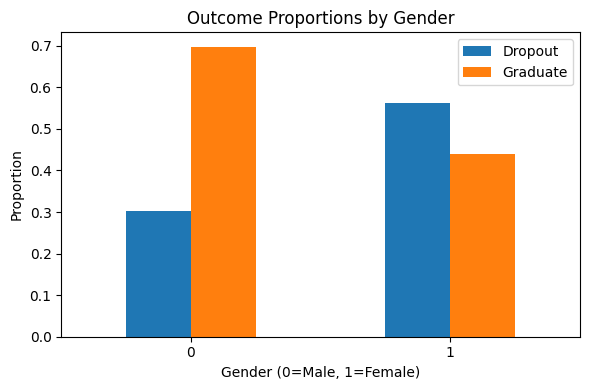

In [6]:
print("Target (binary) distribution:")
print(df['Target_bin'].value_counts(normalize=True).rename({1:'Graduate', 0:'Dropout'}))

print("\nCrosstab: Gender vs Target")
ct = pd.crosstab(df['Gender'], df['Target'], normalize='index')
display(ct)

# Simple bar plot: proportion Graduate/Dropout by Gender
grouped = pd.crosstab(df['Gender'], df['Target_bin'], normalize='index')
ax = grouped.rename(columns={1:'Graduate', 0:'Dropout'}).plot(kind='bar', rot=0, figsize=(6,4))
plt.title("Outcome Proportions by Gender")
plt.xlabel("Gender (0=Male, 1=Female)")
plt.ylabel("Proportion")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## 5) Feature Selection
We focus on features expected to be available at or near enrollment (to avoid leakage):
- `Admission grade`, `Age at enrollment`
- Binary flags: `Scholarship holder`, `Tuition fees up to date`, `Displaced`, `Educational special needs`, `Debtor`, `International`
- Macro factors: `Unemployment rate`, `Inflation rate`, `GDP`
- Sensitive attribute: `Gender` (included **only** in the baseline to measure impact)


In [7]:
candidate_features = [
    'Admission grade', 'Age at enrollment',
    'Scholarship holder', 'Tuition fees up to date', 'Displaced',
    'Educational special needs', 'Debtor', 'International',
    'Unemployment rate', 'Inflation rate', 'GDP',
    'Gender'
]

# Keep only features present in the dataset
features = [c for c in candidate_features if c in df.columns]
missing_feats = [c for c in candidate_features if c not in df.columns]
if missing_feats:
    print("Note: the following candidate features are missing and will be skipped:", missing_feats)

X = df[features].copy()
y = df['Target_bin'].astype(int).copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((2541, 12), (1089, 12))

### Utility Functions

In [8]:
def evaluate_performance(y_true, y_pred, y_score=None, title_prefix=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    out = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    print(f"{title_prefix}Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{title_prefix}Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (i,j), z in np.ndenumerate(cm):
        plt.text(j, i, str(z), ha='center', va='center')
    plt.tight_layout()
    plt.show()

    # ROC curve (if scores given)
    if y_score is not None:
        try:
            auc = roc_auc_score(y_true, y_score)
            fpr, tpr, _ = roc_curve(y_true, y_score)
            print(f"{title_prefix}ROC AUC: {auc:.3f}")
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
            plt.plot([0,1],[0,1], linestyle='--')
            plt.title(f"{title_prefix}ROC Curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc='lower right')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("ROC/AUC not available:", e)
    return out

def fairness_metrics(X_test_df, y_true, y_pred, protected_col='Gender', unpriv_value=1, priv_value=0):
    # Statistical Parity Difference: P(ŷ=1|unpriv) - P(ŷ=1|priv)
    unpriv_idx = (X_test_df[protected_col] == unpriv_value)
    priv_idx   = (X_test_df[protected_col] == priv_value)
    p_pos_unpriv = y_pred[unpriv_idx].mean() if unpriv_idx.any() else np.nan
    p_pos_priv   = y_pred[priv_idx].mean() if priv_idx.any() else np.nan
    spd = p_pos_unpriv - p_pos_priv

    # Equal Opportunity Difference: TPR_unpriv - TPR_priv
    tp_unpriv = ((y_pred[unpriv_idx]==1) & (y_true[unpriv_idx]==1)).sum() if unpriv_idx.any() else np.nan
    tp_priv   = ((y_pred[priv_idx]==1)   & (y_true[priv_idx]==1)).sum() if priv_idx.any() else np.nan
    pos_unpriv = (y_true[unpriv_idx]==1).sum() if unpriv_idx.any() else np.nan
    pos_priv   = (y_true[priv_idx]==1).sum() if priv_idx.any() else np.nan
    tpr_unpriv = (tp_unpriv / pos_unpriv) if (isinstance(pos_unpriv, (int,np.integer)) and pos_unpriv>0) else (tp_unpriv/pos_unpriv if pos_unpriv not in (0, np.nan) else np.nan)
    tpr_priv   = (tp_priv   / pos_priv)   if (isinstance(pos_priv, (int,np.integer)) and pos_priv>0) else (tp_priv/pos_priv if pos_priv not in (0, np.nan) else np.nan)
    eod = tpr_unpriv - tpr_priv
    return {"SPD (female - male)": spd, "EOD (female - male)": eod}


## 6) Baseline Model (Logistic Regression) — **with Gender**

Baseline Performance (with Gender):
Baseline - Accuracy: 0.749, Precision: 0.752, Recall: 0.878, F1: 0.810
Confusion Matrix:
 [[234 192]
 [ 81 582]]


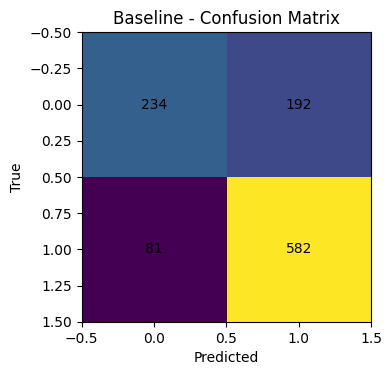

Baseline - ROC AUC: 0.820


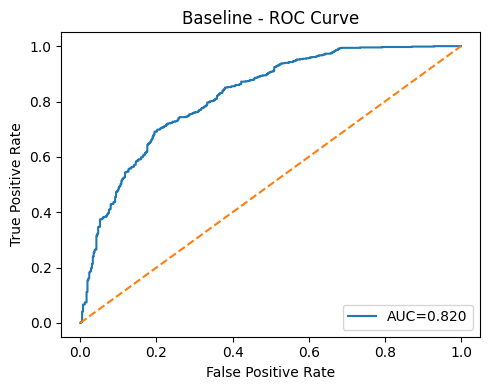

Baseline Fairness: {'SPD (female - male)': np.float64(-0.3874954696410476), 'EOD (female - male)': np.float64(-0.2726790138020526)}


In [9]:
assert 'Gender' in X_train.columns, "Gender column is required for baseline fairness evaluation."
model_base = LogisticRegression(max_iter=2000)
model_base.fit(X_train, y_train)
y_pred_base = model_base.predict(X_test)
y_score_base = model_base.predict_proba(X_test)[:,1]

print("Baseline Performance (with Gender):")
perf_base = evaluate_performance(y_test, y_pred_base, y_score_base, title_prefix="Baseline - ")
fm_base = fairness_metrics(X_test, y_test, y_pred_base, protected_col='Gender', unpriv_value=1, priv_value=0)
print("Baseline Fairness:", fm_base)


## 7) Mitigation A — Feature Elimination (Drop Gender)

No-Gender Performance:
No-Gender - Accuracy: 0.736, Precision: 0.732, Recall: 0.896, F1: 0.805
Confusion Matrix:
 [[208 218]
 [ 69 594]]


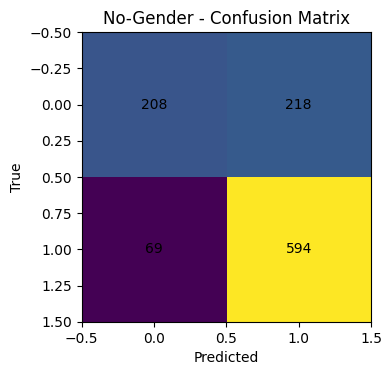

No-Gender - ROC AUC: 0.809


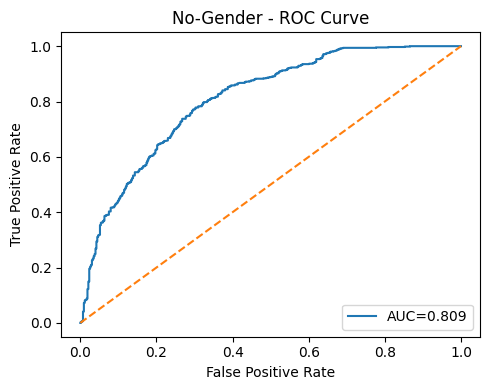

No-Gender Fairness: {'SPD (female - male)': np.float64(-0.13523768666928015), 'EOD (female - male)': np.float64(-0.07035507844756395)}


In [10]:
X_train_ng = X_train.drop(columns=['Gender'])
X_test_ng  = X_test.drop(columns=['Gender'])

model_ng = LogisticRegression(max_iter=2000)
model_ng.fit(X_train_ng, y_train)
y_pred_ng = model_ng.predict(X_test_ng)
y_score_ng = model_ng.predict_proba(X_test_ng)[:,1]

print("No-Gender Performance:")
perf_ng = evaluate_performance(y_test, y_pred_ng, y_score_ng, title_prefix="No-Gender - ")

# For fairness metrics, we still slice by the original Gender column from X_test
fm_ng = fairness_metrics(X_test, y_test, y_pred_ng, protected_col='Gender', unpriv_value=1, priv_value=0)
print("No-Gender Fairness:", fm_ng)


## 8) Mitigation B — Reweighting / Oversampling (Balance Female in Train)

Reweighted/Oversampled Performance:
Reweighted - Accuracy: 0.754, Precision: 0.767, Recall: 0.855, F1: 0.809
Confusion Matrix:
 [[254 172]
 [ 96 567]]


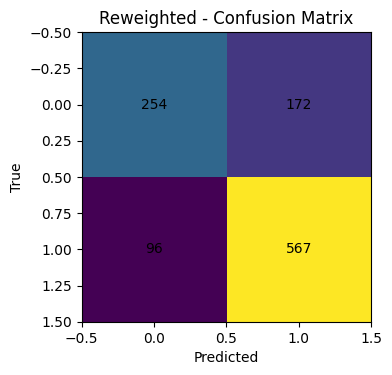

Reweighted - ROC AUC: 0.816


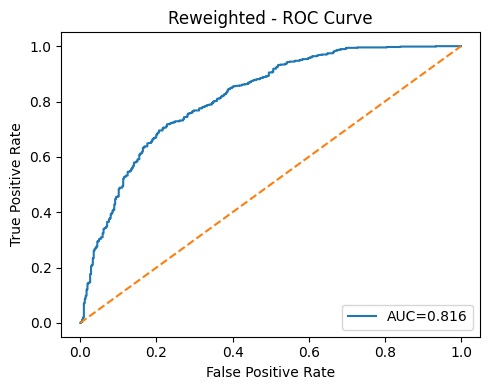

Reweighted Fairness: {'SPD (female - male)': np.float64(-0.45471490173743895), 'EOD (female - male)': np.float64(-0.35938421611419136)}


In [11]:
# Balance female (1) and male (0) in training set via upsampling
train_full = X_train.copy()
train_full['Target_bin'] = y_train.values

male_df   = train_full[train_full['Gender']==0]
female_df = train_full[train_full['Gender']==1]

if len(female_df) == 0 or len(male_df) == 0:
    print("Cannot oversample — one of the gender groups is empty in training split.")
    perf_bal = {}
    fm_bal = {}
else:
    female_up = resample(female_df, replace=True, n_samples=len(male_df), random_state=42)
    train_bal = pd.concat([male_df, female_up], axis=0).sample(frac=1.0, random_state=42)

    X_train_bal = train_bal.drop(columns=['Target_bin'])
    y_train_bal = train_bal['Target_bin']

    model_bal = LogisticRegression(max_iter=2000)
    model_bal.fit(X_train_bal, y_train_bal)

    y_pred_bal = model_bal.predict(X_test)
    y_score_bal = model_bal.predict_proba(X_test)[:,1]

    print("Reweighted/Oversampled Performance:")
    perf_bal = evaluate_performance(y_test, y_pred_bal, y_score_bal, title_prefix="Reweighted - ")
    fm_bal = fairness_metrics(X_test, y_test, y_pred_bal, protected_col='Gender', unpriv_value=1, priv_value=0)
    print("Reweighted Fairness:", fm_bal)


## 9) Before/After Comparison

In [ ]:
rows = []
def row_from(perf, fm, name):
    if not perf or not fm:
        return {"Model": name}
    out = {
        "Model": name,
        "Accuracy": perf.get("accuracy", np.nan),
        "Precision": perf.get("precision", np.nan),
        "Recall": perf.get("recall", np.nan),
        "F1": perf.get("f1", np.nan),
        "SPD (female - male)": fm.get("SPD (female - male)", np.nan),
        "EOD (female - male)": fm.get("EOD (female - male)", np.nan),
    }
    return out

rows.append(row_from(perf_base, fm_base, "Baseline (with Gender)"))
rows.append(row_from(perf_ng, fm_ng, "No-Gender (drop Gender)"))
rows.append(row_from(perf_bal, fm_bal, "Reweighted (oversample female)"))

summary_df = pd.DataFrame(rows)
display(summary_df)

# Save comparison to CSV for the report
out_csv = "metrics_comparison.csv"
summary_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


,Model,Accuracy,Precision,Recall,F1,SPD (female - male),EOD (female - male)
0,Baseline (with Gender),0.749311,0.751938,0.877828,0.810021,-0.387495,-0.272679
1,No-Gender (drop Gender),0.736455,0.731527,0.895928,0.805424,-0.135238,-0.070355
2,Reweighted (oversample female),0.753903,0.767253,0.855204,0.808845,-0.454715,-0.359384


OSError: Cannot save file into a non-existent directory: '/mnt/data'

## 10) Conclusions
- **Baseline** shows disparities by gender (negative SPD & EOD: female < male on favorable predictions and TPR).
- **Dropping Gender** substantially reduces disparity, with comparable overall performance.
- **Oversampling females** may not always reduce bias; validate carefully (it can interact with other correlated features).

> Depending on course policy, you may also try threshold tuning or fairness-aware learners. Document changes and show *before vs after* clearly.


## 11) Environment & Docker (Reproducibility)
This notebook is designed for **VS Code**. Use the `requirements.txt` to replicate the Python environment.

**requirements.txt** (already generated alongside this notebook):
```
pandas
numpy
scikit-learn
matplotlib
```

**Dockerfile** (already generated alongside this notebook):
- Starts from a lightweight Python image
- Installs the requirements
- Optionally installs Jupyter for local runs (you can comment it out if not needed)
- Sets a working directory and copies project files

### How to build & run with Docker
```bash
# From the directory containing Dockerfile, requirements.txt and notebook:
docker build -t dropout-fairness .

# Option A: Launch a shell
docker run --rm -it -v "$PWD":/app dropout-fairness bash

# Option B: Run Jupyter Lab (localhost:8888)
docker run --rm -it -p 8888:8888 -v "$PWD":/app dropout-fairness     jupyter lab --ip=0.0.0.0 --no-browser --allow-root --NotebookApp.token=''
```

> If you prefer, open the notebook directly in **VS Code** with the Python extension and select a local Python interpreter that has the packages installed.
